In [1]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#from google.colab import files
#uploaded = files.upload()

In [2]:
#nltk.download('stopwords')
#nltk.download('wordnet')

In [3]:
from nltk.corpus import stopwords

#import io
# data = pd.read_csv(io.BytesIO(uploaded['IMDB Dataset.csv']))
data = pd.read_csv('IMDB Dataset.csv')

In [4]:
stop_words = set(stopwords.words('english'))

def remove_tags(string):
    removelist = ""
    result = re.sub('','', string)
    result = re.sub('https://.*','', result)
    result = re.sub(r'[^\w'+removelist+']', ' ', result)
    result = result.lower()
    return result




data['review'] = data['review'].apply(lambda w: remove_tags(w))
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
data['review'] = data.review.apply(lemmatize_text)

In [5]:
print(data['review'])

0        one reviewer mentioned watching 1 oz episode h...
1        wonderful little production br br filming tech...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake think zombie ...
4        petter mattei love time money visually stunnin...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary school nu...
49998    going disagree previous comment side maltin on...
49999    one expects star trek movie high art fan expec...
Name: review, Length: 50000, dtype: object


In [6]:
s = 0.0
for i in data['review']:
    word_list = i.split()
    s = s + len(word_list)
print("Average length of each review : ",s/data.shape[0])
pos = 0
for i in range(data.shape[0]):
    if data.iloc[i]['sentiment'] == 'positive':
        pos = pos + 1
neg = data.shape[0]-pos
print("Percentage of reviews with positive sentiment is "+str(pos/data.shape[0]*100)+"%")
print("Percentage of reviews with negative sentiment is "+str(neg/data.shape[0]*100)+"%")


Average length of each review :  123.62852
Percentage of reviews with positive sentiment is 50.0%
Percentage of reviews with negative sentiment is 50.0%


In [7]:
reviews = data['review'].values
labels = data['sentiment'].values
encoder = LabelEncoder()

encoded_labels = encoder.fit_transform(labels)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, test_size=0.2, stratify = encoded_labels)

In [8]:
vocab_size = 3000
oov_tok = ''
embedding_dim = 100
max_length = 200
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [9]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# print(model.summary())
num_epochs = 100
history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1,
                    validation_split=0.1, callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ])

Epoch 1/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 126s 106ms/step - accuracy: 0.7255 - loss: 0.5112 - val_accuracy: 0.8658 - val_loss: 0.3068
Epoch 2/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 121s 107ms/step - accuracy: 0.8907 - loss: 0.2768 - val_accuracy: 0.8790 - val_loss: 0.2933
Epoch 3/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 119s 106ms/step - accuracy: 0.9070 - loss: 0.2452 - val_accuracy: 0.8852 - val_loss: 0.2812
Epoch 4/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 119s 106ms/step - accuracy: 0.9289 - loss: 0.1974 - val_accuracy: 0.8850 - val_loss: 0.2875
Epoch 5/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 118s 105ms/step - accuracy: 0.9361 - loss: 0.1679 - val_accuracy: 0.8813 - val_loss: 0.3027
Epoch 6/100
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 118s 105ms/step - accuracy: 0.9528 - loss: 0.1331 - val_accuracy: 0.8755 - val_loss: 0.3447


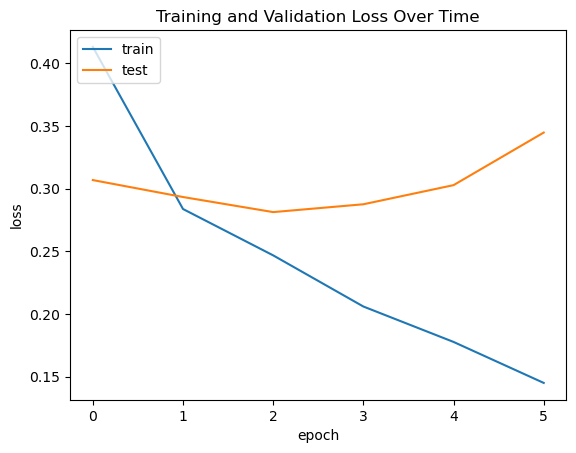

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training and Validation Loss Over Time")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step
Accuracy of prediction on test set :  0.8784


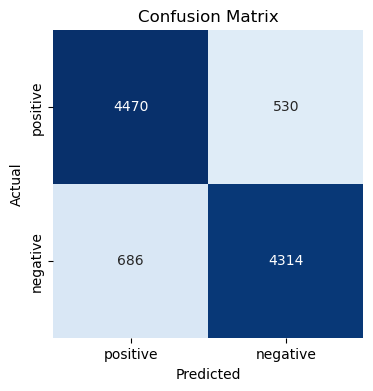

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
The movie was very touching and heart whelming
Predicted sentiment :  Positive
I have never seen a terrible movie like this
Predicted sentiment :  Negative
the movie plot is terrible but it had good acting
Predicted sentiment :  Negative


In [12]:
prediction = model.predict(test_padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))
cm = tf.math.confusion_matrix(test_labels, pred_labels)
CLASS_NAMES=['positive','negative']
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(2) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(2) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

sentence = ["The movie was very touching and heart whelming",
            "I have never seen a terrible movie like this",
            "the movie plot is terrible but it had good acting"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, padding='post', maxlen=max_length)

prediction = model.predict(padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s)